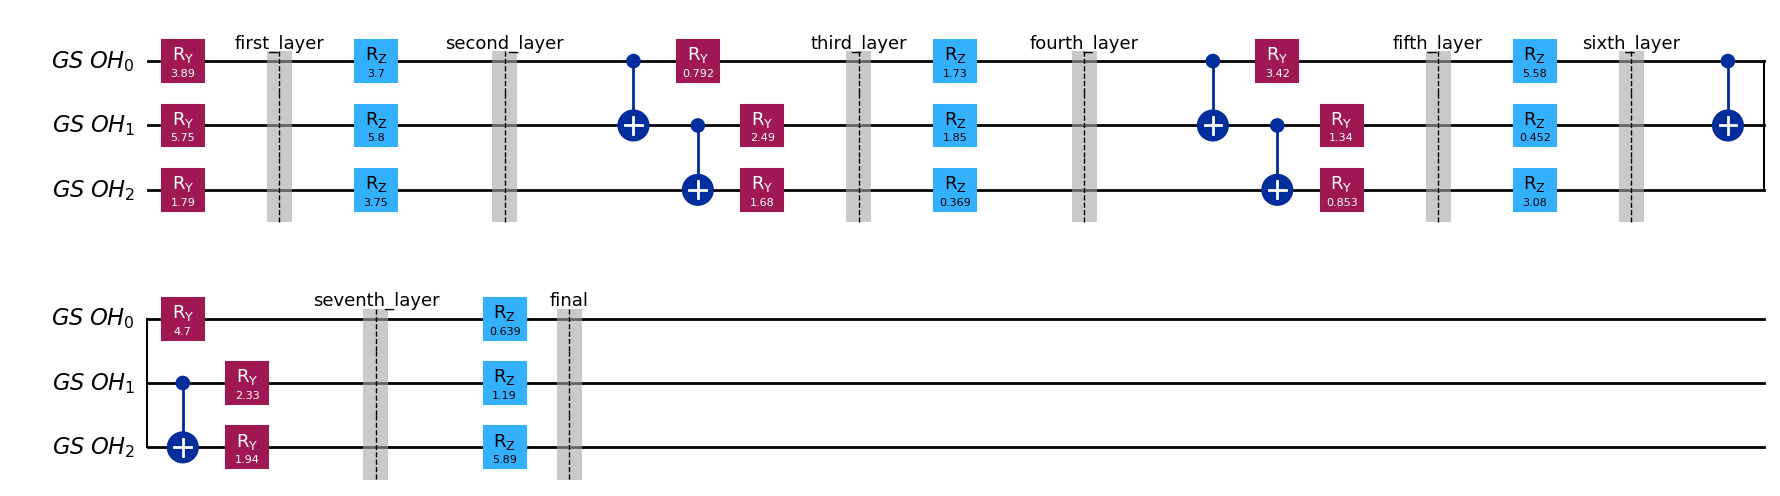

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Qiskit Runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit.circuit.library import MCPhaseGate
import numpy as np
from qiskit.quantum_info import Operator
N = 3
N_layers = 8
theta =2*np.pi* np.random.rand(N_layers*N)


def var_qc(N,theta):
    
    hamiltonian = QuantumRegister(N, name="GS OH")


    qc = QuantumCircuit(hamiltonian)
    for i in range(N):
        qc.ry(theta[i], hamiltonian[i])
    qc.save_statevector(label=f'first_layer')

    for i in range(N):
        qc.rz(theta[i+N], hamiltonian[i])
    qc.save_statevector(label=f'second_layer')

    for i in range(N-1):
        qc.cx(i,i+1)

    for i in range(N):
        qc.ry(theta[i+2*N], hamiltonian[i])
    qc.save_statevector(label=f'third_layer')

    for i in range(N):
        qc.rz(theta[i+3*N], hamiltonian[i])
    qc.save_statevector(label=f'fourth_layer')

    for i in range(N-1):
        qc.cx(i,i+1)

    for i in range(N):
        qc.ry(theta[i+4*N], hamiltonian[i])
    qc.save_statevector(label=f'fifth_layer')

    for i in range(N):
        qc.rz(theta[i+5*N], hamiltonian[i])
    qc.save_statevector(label=f'sixth_layer')

    for i in range(N-1):
        qc.cx(i,i+1)

    for i in range(N):
        qc.ry(theta[i+6*N], hamiltonian[i])
    qc.save_statevector(label=f'seventh_layer')

    for i in range(N):
        qc.rz(theta[i+7*N], hamiltonian[i])
    qc.save_statevector(label=f'final')

    return qc

qc = var_qc(N,theta)
qc.draw(output="mpl", style='iqp', cregbundle=False)

In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator,StatevectorSimulator
from qiskit.quantum_info import SparsePauliOp, Statevector
from numpy import linalg
import matplotlib.pyplot as plt

def grad_eval(N, N_layers, theta,eps,op):
    simulator = StatevectorSimulator()

    grad = np.zeros(N_layers*N)
    

    epsmat = eps*np.eye(N_layers*N)
   
    for it1 in range(N_layers*N):
        theta_plus = theta+epsmat[it1,:]
        theta_minus = theta-epsmat[it1,:]
        
        if theta_plus[it1] > 2*np.pi:
            theta_plus[it1] -= 2*np.pi
        elif theta_minus[it1]<0:
            theta_minus[it1] += 2*np.pi

        
        qc_plus = var_qc(N,theta_plus )
        qc_minus = var_qc(N,theta_minus )

        cc_plus = transpile(qc_plus,simulator)
        result_plus = simulator.run(cc_plus).result()
        statevector_plus = result_plus.get_statevector()

        cc_minus = transpile(qc_minus,simulator)
        result_minus = simulator.run(cc_minus).result()
        statevector_minus = result_minus.get_statevector()

        
        grad_el = (statevector_plus.expectation_value(op).real-statevector_minus.expectation_value(op).real)/(2*eps)
        
        grad[it1] = grad_el
    return grad

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator,StatevectorSimulator
from qiskit.quantum_info import SparsePauliOp, Statevector
from numpy import linalg
import matplotlib.pyplot as plt
from numpy import genfromtxt

D = 0.0801
B = .001
E = 1e5
t=2*np.pi/3
#t = np.pi/2
N = 3
N_layers = 8
h = 1.055e-34;
delta = 2*np.pi*1.667e9
Kb = 1.38e-23;

me = 1.66 *3.336e-30
mb = 9.274e-24
B= mb*B/Kb
E = me *E/Kb
D = h*delta/Kb

ham = np.array([[-1/2*D - 6/5*B , 0 , 0 , 0 , 3/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t) , 0,  0],[0 , -1/2*D - 2/5*B  ,0 , 0 , -np.sqrt(3)/5*E*np.sin(t) , 1/5*E*np.cos(t) , -2/5*E*np.sin(t) , 0],[0 , 0  ,-1/2*D + 2/5*B , 0 , 0 , -2/5*E*np.sin(t) , -1/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t)],[ 0 , 0  ,0 , -1/2*D + 6/5*B , 0 , 0 , -np.sqrt(3)/5*E*np.sin(t) , -3/5*E*np.cos(t)],[3/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t) , 0 , 0 , 1/2*D - 6/5*B , 0 , 0 , 0],[-np.sqrt(3)/5*E*np.sin(t) , 1/5*E*np.cos(t) , -2/5*E*np.sin(t) , 0 , 0 , 1/2*D - 2/5*B , 0 , 0],[ 0 , -2/5*E*np.sin(t) , -1/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t) , 0 , 0 , 1/2*D + 2/5*B , 0],[0 , 0 , -np.sqrt(3)/5*E*np.sin(t) , -3/5*E*np.cos(t) , 0 , 0  ,0 , 1/2*D + 6/5*B]])
target_val = min(linalg.eigvals(ham))
print(target_val)
eps = 1e-4
eta = .2
simulator = StatevectorSimulator()
Max_it = 300

theta_nat =2*np.pi* np.random.rand(N_layers*N)

res_nat = []

for it in range(Max_it):
    qc_nat = var_qc(N,theta_nat )

    #simulator = AerSimulator.from_backend(statevector_nat)
    cc_nat = transpile(qc_nat,simulator)
    result_nat = simulator.run(cc_nat).result()
    
    statevector_nat = result_nat.data(0)['final']
    
    



    op = Operator(ham)

    # Compute expectation value
    expectation_value_nat = statevector_nat.expectation_value(op).real
    
    I = np.eye(2)
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    q = np.zeros(N_layers*N*N_layers*N).reshape(N_layers*N,N_layers*N)
    merged_sv = [result_nat.data(0)['first_layer'],result_nat.data(0)['second_layer'],result_nat.data(0)['third_layer'],result_nat.data(0)['fourth_layer'],result_nat.data(0)['fifth_layer'],result_nat.data(0)['sixth_layer'],result_nat.data(0)['seventh_layer'],result_nat.data(0)['final']]
    
    PY = [np.kron(np.kron(Y,I),I),np.kron(np.kron(I,Y),I),np.kron(np.kron(I,I),Y)]   
    PZ = [np.kron(np.kron(Z,I),I),np.kron(np.kron(I,Z),I),np.kron(np.kron(I,I),Z)] 
    for layer in range(N_layers):
        for it2 in range(N):
            for it3 in range(it2,N):
                if layer%2 ==0:
                    q[it2+layer*3,it3+layer*3]  = merged_sv[layer].expectation_value(Operator(PY[it2].dot(PY[it3]))).real -  (merged_sv[layer].expectation_value(Operator(PY[it2])).real)* (merged_sv[layer].expectation_value(Operator(PY[it3])).real ) 
                    q[it3+layer*3,it2+layer*3] = q[it2+layer*3,it3+layer*3]
                else:
                    q[it2+layer*3,it3+layer*3]  = merged_sv[layer].expectation_value(Operator(PZ[it2].dot(PZ[it3]))).real -  (merged_sv[layer].expectation_value(Operator(PZ[it2])).real)* (merged_sv[layer].expectation_value(Operator(PZ[it3])).real ) 
                    q[it3+layer*3,it2+layer*3] = q[it2+layer*3,it3+layer*3]

               
    q = q*(1/4)
    g_plus = linalg.pinv(q)    
    
    grad_nat = grad_eval(N, N_layers, theta_nat,eps,op)
    

    

   

    

    

    
    
   
    # Print result
    print("exp val nat:", expectation_value_nat,"iteration",it)
    
    res_nat.append(expectation_value_nat)
    theta_nat = theta_nat-eta*g_plus.dot(grad_nat)
    
    for it1 in range(N_layers*N):
        if theta[it1] > 2*np.pi:
            theta[it1] = theta[it1]-2*np.pi
        elif theta[it1]<0:
            theta[it1] = theta[it1]+2*np.pi
        if theta_nat[it1] > 2*np.pi:
            theta_nat[it1] = theta_nat[it1]-2*np.pi
        elif theta_nat[it1]<0:
            theta_nat[it1] = theta_nat[it1]+2*np.pi


np.savetxt("res_nat_8.csv", res_nat, delimiter=",")

x_nat = range(1,len(res_nat)+1)
res_target = target_val*np.ones(len(res_nat))
# Create the plot
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(x_nat, res_nat, linestyle='-', label='natural', color='r')  # Line for res2
plt.plot(x_nat,res_target, linestyle='--', label='target', color='g')
# Labels and title
plt.xlabel("Iterations")
plt.ylabel("Energy")


# Add legend
plt.legend()

# Show plot
plt.show()

-0.04714783061568914
exp val nat: 0.004845031148090116 iteration 0
exp val nat: -0.011956202631884372 iteration 1
exp val nat: -0.02311212758294205 iteration 2
exp val nat: -0.026485585805693962 iteration 3
exp val nat: -0.027823137831644508 iteration 4
exp val nat: -0.028900387745710875 iteration 5
exp val nat: -0.02990793608357109 iteration 6
exp val nat: -0.030856640848777112 iteration 7
exp val nat: -0.031746823194109625 iteration 8
exp val nat: -0.03257935647398467 iteration 9
exp val nat: -0.03335591181403 iteration 10
